In [73]:
# %pip install numpy
# %pip install opencv-python
# %pip install tensorflow

In [74]:
import numpy as np  
import cv2 
import os
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential


In [75]:
train_folder, test_folder, val_folder = "./train", "./test", "./val"

In [76]:
labels = ["NORMAL", "PNEUMONIA"] 
IMG_SIZE = 144

In [77]:
def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        print(path)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resize_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resize_img_array, class_num])
            except Exception as e:
                print(e)
    
    return np.array(data, dtype=object)

In [78]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

./train\NORMAL


./train\PNEUMONIA
./test\NORMAL
./test\PNEUMONIA
./val\NORMAL
./val\PNEUMONIA


In [79]:
normal_count=0
pneumonia_count=0
for i in train:
    if(i[1] == 0):
        normal_count+=1
    else:
        pneumonia_count+=1
        
print("Normal: ", normal_count)
print("Pneumonia: ", pneumonia_count)

Normal:  1341
Pneumonia:  3875


In [80]:
X_train,y_train = [],[]
X_test,y_test = [],[]
X_val,y_val = [],[]

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [81]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [82]:
X_train.shape

(5216, 144, 144)

In [83]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [84]:
y_train.dtype, X_train.dtype

(dtype('int32'), dtype('float64'))

In [85]:
X_train.shape

(5216, 144, 144, 1)

In [86]:
# convert_to_tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int8)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int8)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int8)

In [87]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [88]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [89]:
base_model= Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:])

model = Sequential()

model.add(base_model)
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 144, 144, 32)      320       
                                                                 
 activation_10 (Activation)  (None, 144, 144, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 72, 72, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 72, 72, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 72, 72, 64)        0         
                                                      

In [109]:
model_name="pneumonia_model_img_144_lr_1e-5_epochs_50_2nd_run.bin"
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[callback])
scores = model.evaluate(X_test, y_test)

model.save(model_name)

Epoch 1/50
163/163 [==============================] - 84s 503ms/step - loss: 0.1115 - accuracy: 0.9576 - val_loss: 0.3140 - val_accuracy: 0.8125
Epoch 2/50
163/163 [==============================] - 100s 614ms/step - loss: 0.1038 - accuracy: 0.9618 - val_loss: 0.2851 - val_accuracy: 0.9375
Epoch 3/50
163/163 [==============================] - 96s 587ms/step - loss: 0.1102 - accuracy: 0.9607 - val_loss: 0.2849 - val_accuracy: 0.9375
Epoch 4/50
163/163 [==============================] - 93s 573ms/step - loss: 0.1073 - accuracy: 0.9603 - val_loss: 0.2550 - val_accuracy: 0.9375
Epoch 5/50
20/20 [==============================] - 3s 146ms/step - loss: 0.4029 - accuracy: 0.8237
INFO:tensorflow:Assets written to: pneumonia_model_img_144_lr_1e-5_epochs_50_2nd_run.bin\assets


INFO:tensorflow:Assets written to: pneumonia_model_img_144_lr_1e-5_epochs_50_2nd_run.bin\assets


In [110]:
# scores
print("Test loss {}".format(scores[0]))
print("Test accuracy {}".format(scores[1]))

Test loss 0.40286505222320557
Test accuracy 0.8237179517745972


In [ ]:
# visualization

import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [112]:
# predict classes

prediction = (model.predict(X_test) > 0.5).astype("int32")
prediction = prediction.reshape(1, -1)[0]
prediction[:15]

20/20 [==============================] - 2s 92ms/step


array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1])

In [113]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return{"TP": TP, "FP": FP, "TN": TN, "FN": FN}

In [114]:
cm = perf_measure(y_test, prediction)
cm


{'TP': 370, 'FP': 90, 'TN': 144, 'FN': 20}

In [115]:
print("accuracy: ", (cm["TP"] + cm["TN"]) / (cm["TP"] + cm["TN"] + cm["FP"] + cm["FN"]))
print("precision: ", cm["TP"] / (cm["TP"] + cm["FP"]))
print("recall: ", cm["TP"] / (cm["TP"] + cm["FN"]))
print("specificity: ", cm["TN"] / (cm["TN"] + cm["FP"]))

accuracy:  0.8237179487179487
precision:  0.8043478260869565
recall:  0.9487179487179487
specificity:  0.6153846153846154


<Axes: >

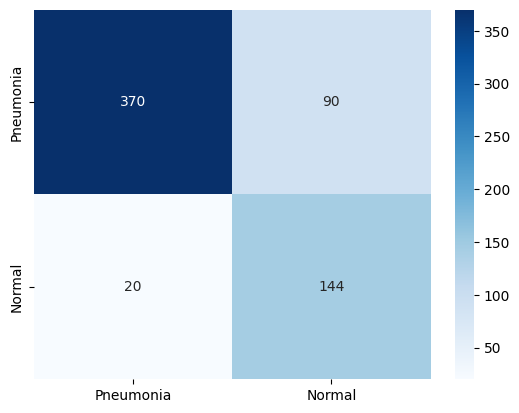

In [116]:
import seaborn as sns

sns.heatmap([[cm["TP"], cm["FP"]], [cm["FN"], cm["TN"]]], annot=True, fmt="d", cmap="Blues", xticklabels=["Pneumonia", "Normal"], yticklabels=["Pneumonia", "Normal"])

In [98]:
# correct and incorrect

correct = np.nonzero(prediction == y_test)[0]
incorrect = np.nonzero(prediction != y_test)[0]

In [99]:
print(len(correct), " classified correctly")
print(len(incorrect), " classified incorrectly")

520  classified correctly
104  classified incorrectly


In [ ]:
model_name="cnn_model.bin"

In [76]:
# load model and predict some some external photo

labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model(model_name) # load model

In [77]:
prediction = model.predict([prepare("./test/NORMAL/IM-0001-0001.jpeg")])
print(labels[int(prediction[0])])

1/1 [==============================] - 1s 713ms/step
NORMAL


C:\Users\USER\AppData\Local\Temp\ipykernel_24292\367948355.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(labels[int(prediction[0])])


In [78]:
prediction = model.predict([prepare("./test/PNEUMONIA/person100_bacteria_475.jpeg")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 125ms/step
PNEUMONIA


C:\Users\USER\AppData\Local\Temp\ipykernel_24292\2397977092.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(labels[int(prediction[0])])
